# Workbook 07 - Dimension Reduction
by [David Elliott](https://eldave93.netlify.app/)

1. [Workspace Setup](#setup)

2. [Problem Understanding](#problem)

3. [Data Pre-Processing/EDA](#eda)

4. [Basic Model](#model)

5. [Feature Selection](#select)

6. [Feature Extraction](#extract)

This workbook we are going to be looking at how we can reduce the number of attributes to those that might be useful for our model. We've been so far working with data with a few attributes (features), but sometimes you have lots of attributes and don't know where to start!

In order to reduce a models complexity, run time, and potential for overfitting to the training data, dimension reduction techniques can be used. Broadly they can be grouped into methods that create a subset of the original set of features (Feature Selection) and methods that create new synthetic features through combining the original features and discarding less important ones (Feature Extraction). Essentially we want to remove "uninformative infromation" and retain useful bits<sup>1</sup>. If you have too many features, it may be that some of them are highly correlated and therefore redundant. Therefore we can either select just some of them, or compress them onto a lower dimensional subspace<sup>2</sup>.

---
1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

2. Raschka, 2016

# 1. Workspace Setup

Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.A. Google Colab
If you are not using google colab then you can skip this section. 

If you are using colab we will first need to have the libaries for the runtime and files associated with this workbook uploaded to the temporary file store. You also need to set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. The below code will do all this for you.

__Required:__ After running this code make sure to restart the runtime to ensure everything works correctly (Runtime > Restart runtime).

In [1]:
import sys
import os

try:
    import google.colab
    COLAB=True
    
    # set the workbook code
    WORKSHOP_NAME = "07-dimension-reduction"
    # set the folder name
    FOLDER_NAME = "machine-learning-workbooks-main"

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists(FOLDER_NAME):
        # get the zip of the workbooks
        !wget https://github.com/Eldave93/machine-learning-workbooks/archive/refs/heads/main.zip
        # unzip the file
        !unzip main.zip
        # install the libaries
        !{sys.executable} -m pip install -r ./{FOLDER_NAME}/scripts/requirements.txt
          
    print("Setting working directory to:")
    %cd ./{FOLDER_NAME}/{WORKSHOP_NAME}
    
except:
    COLAB=False
    print("Colab is not being used")

Colab is not being used


## 1.1. Packages

If your using a local workspace you will need all the following packages to run this notebook. If you do not already have them, or you want to ensure you are using the same versions as used when created, you could run `!{sys.executable} -m pip install -r ../scripts/requirements.txt` to install them for you.

In [2]:
import os # locating directories
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings # prevent warnings

sys.path.append('../scripts') # add scripts to the path for use later
sns.set(rc={'figure.figsize': (14, 8)}) # For plot sizes
np.random.seed(42)  # to make this notebook's output identical at every run

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 1.2. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workbook folder (e.g. `03-dimension-reduction`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).
- This may not work if you don't have the same version of `IPython.display` as the machine that created them:
    ```
    ImportError: cannot import name 'Code' from 'IPython.display' (/usr/local/lib/python3.7/dist-packages/IPython/display.py)
    ```
    If so run the auto-install above or manually run `!pip install ipython==7.20`.

---

# 2. Problem Understanding <a id='problem'></a>

You have been hired by a new dealership who want to know what aspects of a car leads to its retail price. They want you to build a model to price new cars based on their properties (we're going to pretend RRP is not a thing). 

We can start by downloading the data if you do not already have it.

__Note:__ [Data sourse](https://archive.ics.uci.edu/ml/datasets/Automobile)

In [3]:
# download from the sourse
import requests

if not os.path.exists("./Data/imports-85.data"):
    r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data")
    open("./Data/imports-85.data" , 'wb').write(r.content)

if not os.path.exists("./Data/imports-85.names"):
    r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names")
    open("./Data/imports-85.names" , 'wb').write(r.content)

Lets start by looking at what attributes are available to us...

In [4]:
cars_info = open("./Data/imports-85.names", "r")
for i, line in enumerate(cars_info):
    if i>57 and i<89: # get lines with attribute info
        print(line)

cars_info.close()

     Attribute:                Attribute Range:

     ------------------        -----------------------------------------------

  1. symboling:                -3, -2, -1, 0, 1, 2, 3.

  2. normalized-losses:        continuous from 65 to 256.

  3. make:                     alfa-romero, audi, bmw, chevrolet, dodge, honda,

                               isuzu, jaguar, mazda, mercedes-benz, mercury,

                               mitsubishi, nissan, peugot, plymouth, porsche,

                               renault, saab, subaru, toyota, volkswagen, volvo

  4. fuel-type:                diesel, gas.

  5. aspiration:               std, turbo.

  6. num-of-doors:             four, two.

  7. body-style:               hardtop, wagon, sedan, hatchback, convertible.

  8. drive-wheels:             4wd, fwd, rwd.

  9. engine-location:          front, rear.

 10. wheel-base:               continuous from 86.6 120.9.

 11. length:                   continuous from 141.1 to 208.1.

 12. width

## 2.1. Data

From the attribute descriptions you should be able to see we have lots of different information on the cars which we can help to use to determine the price.

Lets read in the data and have a look.

In [5]:
cars_cols = ["symboling", "normalized-losses", "make", "fuel-type",
             "aspiration", "num-of-doors", "body-style", "drive-wheels",
             "engine-location", "wheel-base", "length", "width", "height",
             "curb-weight", "engine-type", "num-of-cylinders", "engine-size",
             "fuel-system", "bore", "stroke", "compression-ratio", "horsepower",
             "peak-rpm", "city-mpg", "highway-mpg", "price"]
cars_df = pd.read_csv("./Data/imports-85.data", names = cars_cols, na_values="?")
cars_df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


To start with, for this task we are just going to use features of the car and not the ones about insurance (i.e. first two attributes).

In [6]:
cars_df.drop(["symboling", "normalized-losses"], axis=1, inplace=True)

Before moving on lets have a look at some broad information on our data.

In [7]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               205 non-null    object 
 1   fuel-type          205 non-null    object 
 2   aspiration         205 non-null    object 
 3   num-of-doors       203 non-null    object 
 4   body-style         205 non-null    object 
 5   drive-wheels       205 non-null    object 
 6   engine-location    205 non-null    object 
 7   wheel-base         205 non-null    float64
 8   length             205 non-null    float64
 9   width              205 non-null    float64
 10  height             205 non-null    float64
 11  curb-weight        205 non-null    int64  
 12  engine-type        205 non-null    object 
 13  num-of-cylinders   205 non-null    object 
 14  engine-size        205 non-null    int64  
 15  fuel-system        205 non-null    object 
 16  bore               201 non

We have a mix of numerical and categorical features in this data. Lets now take a note of what these are as we will need to treat them differently in our model.

In [8]:
cat_feats = list(cars_df.columns[cars_df.dtypes =="object"])
num_feats = list(cars_df.columns[cars_df.dtypes !="object"])
num_feats.remove('price')

# 3. Data Pre-Processing/EDA <a id='eda'></a>

We are going to do a mix of EDA and pre-processing in this notebook. We're not going to spend as much time here as you normally would just so we can get to the dimension reduction, but there are extra tasks for you to practice your pre-processing and EDA skills.

Instead we'll focus mostly on preparing the categorical features for later analysis.

To start with, we don't have too many missing attributes so lets just keep records that are complete

In [9]:
cars_df.dropna(inplace=True)

## 3.1. Train-Test Split

Lets start by splitting our data up.

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cars_df, random_state=42, test_size=0.2)

X_train, y_train = train_set.drop("price", axis=1), train_set["price"]
X_test, y_test = test_set.drop("price", axis=1), test_set["price"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(154, 23)
(154,)
(39, 23)
(39,)


## `num-of-cylinders` and `num-of-doors`

These two features are currently strings, but as they reprent things like numbers of cylinders and doors, we could convert these into numerical values easily.

Lets start with `num-of-cylinders`. We're going to create a function that we can use with a `FunctionTransformer` and `ColumnTransformer` (see prior workbooks).

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

def digit_int(df):
    # a list of written digits
    str_units = ["zero", "one", "two", "three", "four", "five", 
                 "six", "seven", "eight", "nine", "ten"]

    # get a list of digits 0-10
    num_units = list(range(11))

    # using zip() to convert lists to dictionary
    map_dict = dict(zip(str_units, num_units))
    
    # change the strings into their int counterparts
    df = df.replace(map_dict)
    
    return df

# add the function into a `ColumnTransformer` for demonstration
digit_int_ct = ColumnTransformer(
    [("digit_int", FunctionTransformer(digit_int), ["num-of-cylinders", "num-of-doors"])], 
    remainder="drop")

# demonstate how this function works
X_train_ = pd.DataFrame(digit_int_ct.fit_transform(X_train), 
                        columns = ["num-of-cylinders", "num-of-doors"])

display(X_train[["num-of-cylinders", "num-of-doors"]].head())
display(X_train_.head())

,num-of-cylinders,num-of-doors
91,four,two
118,four,two
175,four,four
37,four,two
148,four,four


,num-of-cylinders,num-of-doors
0,4,2
1,4,2
2,4,4
3,4,2
4,4,4


As we now have a function to replace the numbers, we can remove these features from our `cat_feats` list

In [12]:
cat_feats.remove("num-of-cylinders")
cat_feats.remove("num-of-doors")

## `engine-location`, `fuel-system`, and `make`

If we have a look at these variables, you will notice that they each have at least one category level with very few instances in the data. This will be an issue later as it can mean there is not enough variation in the category to be able to learn from. Also when we assess our models performance (e.g. cross-validation), it will mean sometimes our training and validation sets will have different number of columns after we have encoded these levels.

__Note:__ Im checking the full data (training and test) as if I just look at one and not the other we may not see all of them.

In [13]:
low_variation = ['engine-location', 'fuel-system', 'make']
for feat_name in low_variation:
    display(cars_df[feat_name].value_counts())

front    190
rear       3
Name: engine-location, dtype: int64

mpfi    88
2bbl    64
idi     19
1bbl    11
spdi     9
mfi      1
spfi     1
Name: fuel-system, dtype: int64

toyota           32
nissan           18
honda            13
mitsubishi       13
volkswagen       12
subaru           12
mazda            12
volvo            11
peugot           11
bmw               8
dodge             8
mercedes-benz     8
plymouth          7
saab              6
audi              6
porsche           4
alfa-romero       3
jaguar            3
chevrolet         3
isuzu             2
mercury           1
Name: make, dtype: int64

As `engine-location` is a binary categorical variable and there is only 3 rear wheel drive cars we'll just remove this feature entirely.

In [14]:
drop_list = ["engine-location"]
cat_feats.remove('engine-location')

For the others let make a function that if it finds any of the strings for the limited levels, it turns it to NA.

__Notes:__ 
- we're going to use this function now rather than in a pipeline as this will remove rows, which typical inputs into sklearn pipelines don't do.
- the `OneHotEncoder` also has `min_frequency` which will do the same thing if your on scikit-learn version 1.1.

In [15]:
def remove_low_levels(X,y):
    df_ = pd.concat([X,y], axis=1)
    remove_str = "mfi|spfi|jaguar|porsche|mercury|isuzu|chevrolet|alfa-romero"
    for feat_name in df_.columns:
        df_[feat_name] = df_[feat_name].replace(remove_str, np.NaN, regex=True)
        
    df_.dropna(inplace = True)
    return df_.iloc[:,:-1], df_.iloc[:,-1]

X_train, y_train = remove_low_levels(X_train, y_train)
X_test, y_test = remove_low_levels(X_test[cat_feats], y_test)

display(X_train['fuel-system'].value_counts())
display(X_train['make'].value_counts())

mpfi    62
2bbl    46
idi     17
1bbl    10
spdi     7
Name: fuel-system, dtype: int64

toyota           21
nissan           17
honda            12
mazda            12
volvo            11
volkswagen       11
subaru           10
peugot           10
mitsubishi        8
dodge             6
saab              6
mercedes-benz     6
bmw               5
audi              5
plymouth          2
Name: make, dtype: int64

## Categorical features

For the categorical features we now need to one-hot encode them.

In [16]:
from sklearn.preprocessing import OneHotEncoder
onehot_transform = ColumnTransformer(
    [("encode", OneHotEncoder(drop="first"), cat_feats)], remainder="passthrough").fit(X_train)

X_train_ = pd.DataFrame(onehot_transform.transform(X_train), columns = onehot_transform.get_feature_names_out())

X_train_.columns = X_train_.columns.str.replace('encode__', '')
X_train_.columns = X_train_.columns.str.replace('remainder__', '')
X_train_

,make_bmw,make_dodge,make_honda,make_mazda,make_mercedes-benz,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_saab,...,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1918,four,97,3.15,3.29,9.4,69.0,5200.0,31,37
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1918,four,90,2.97,3.23,9.4,68.0,5500.0,37,41
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2414,four,122,3.31,3.54,8.7,92.0,4200.0,27,32
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2236,four,110,3.15,3.58,9.0,86.0,5800.0,27,33
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2420,four,108,3.62,2.64,9.0,82.0,4800.0,23,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3075,four,120,3.46,3.19,8.4,97.0,5000.0,19,24
138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3230,six,209,3.62,3.39,8.0,182.0,5400.0,16,22
139,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3095,six,181,3.43,3.27,9.0,152.0,5200.0,17,22
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2661,five,136,3.19,3.4,8.5,110.0,5500.0,19,24


Notice how we used `drop="first"`. This is important when using a basic linear regression as...

In [17]:
cats_list = onehot_transform.named_transformers_['encode'].categories_
dropped_idx = onehot_transform.named_transformers_['encode'].drop_idx_
dropped = []
for i, index_names in enumerate(cats_list):
    dropped.append(index_names[dropped_idx[i]])

dict(zip(cat_feats, dropped))

{'make': 'audi',
 'fuel-type': 'diesel',
 'aspiration': 'std',
 'body-style': 'convertible',
 'drive-wheels': '4wd',
 'engine-type': 'dohc',
 'fuel-system': '1bbl'}

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display='diagram')
pre_processing = [
    # for each feature do the following....
    ("feature_transformation", ColumnTransformer([
        # ...remove from the data.
        ("drop", "drop", drop_list),
        # onehot encode
        ("encode", OneHotEncoder(drop="first"), cat_feats),
        ("digit_int", FunctionTransformer(digit_int), ["num-of-cylinders", "num-of-doors"]),
        #("scale", StandardScaler(),  num_feats),
        ],remainder="passthrough"))]

pre_processing_pipe =  Pipeline(pre_processing)
pre_processing_pipe.fit(X_train)

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['engine-location']),
                                                 ('encode',
                                                  OneHotEncoder(drop='first'),
                                                  ['make', 'fuel-type',
                                                   'aspiration', 'body-style',
                                                   'drive-wheels',
                                                   'engine-type',
                                                   'fuel-system']),
                                                 ('digit_int',
                                                  FunctionTransformer(func=<function digit_int at 0x00000142954A98B0>),
                                                  ['num-of-cylinders',
                                                   'num-of-doors'])]))])

In [19]:
onehot_feats = list(pre_processing_pipe.named_steps['feature_transformation'].named_transformers_['encode'].get_feature_names_out())
onehot_feats.append("num-of-cylinders")
onehot_feats.append("num-of-doors")
onehot_feats.extend(num_feats)
X_train_ = pd.DataFrame(pre_processing_pipe.transform(X_train), 
                        columns = onehot_feats)

X_train_

,make_bmw,make_dodge,make_honda,make_mazda,make_mercedes-benz,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_saab,...,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,54.5,1918.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,50.8,1918.0,90.0,2.97,3.23,9.4,68.0,5500.0,37.0,41.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53.9,2414.0,122.0,3.31,3.54,8.7,92.0,4200.0,27.0,32.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53.3,2236.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.9,2420.0,108.0,3.62,2.64,9.0,82.0,4800.0,23.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,56.7,3075.0,120.0,3.46,3.19,8.4,97.0,5000.0,19.0,24.0
138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.7,3230.0,209.0,3.62,3.39,8.0,182.0,5400.0,16.0,22.0
139,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,55.1,3095.0,181.0,3.43,3.27,9.0,152.0,5200.0,17.0,22.0
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.1,2661.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,24.0


---

# 4. Basic Model <a id='model'></a>

Lets start by building a basic model to use as a benchmark when

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

scores = cross_validate(DummyRegressor(), X_train_, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,-0.07,0.0
1,0.0,0.0,-0.03,0.0
2,0.0,0.0,-0.07,0.0
3,0.0,0.0,-0.01,0.0
4,0.0,0.0,-0.01,0.0
mean,0.0,0.0,-0.04,0.0
sd,0.0,0.0,0.03,0.0


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

lin_pipe_steps = pre_processing.copy()

lin_pipe_steps.extend([("model", LinearRegression())])

lin_pipe = Pipeline(lin_pipe_steps)

display(lin_pipe)

tidy_scores(cross_validate(lin_pipe, X_train, y_train, cv=KFold(5, shuffle=True, random_state=42), 
                           return_train_score=True, verbose=2))

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['engine-location']),
                                                 ('encode',
                                                  OneHotEncoder(drop='first'),
                                                  ['make', 'fuel-type',
                                                   'aspiration', 'body-style',
                                                   'drive-wheels',
                                                   'engine-type',
                                                   'fuel-system']),
                                                 ('digit_int',
                                                  FunctionTransformer(func=<function digit_int at 0x00000142954A98B0>),
                                                  ['num-of-cylinders',
                                                   'num-of-doors'])])),
                ('model', LinearRegression())])

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.00,0.75,0.98
1,0.01,0.01,0.82,0.97
2,0.00,0.01,0.92,0.97
3,0.01,0.01,0.90,0.97
4,0.01,0.00,0.83,0.97
mean,0.01,0.01,0.84,0.97
sd,0.00,0.00,0.06,0.00


In [22]:
from scipy import stats
import numpy as np

column_names = X_train_.columns

for i in range(X_train_.shape[-1]):

    corr = pd.DataFrame(stats.pearsonr(X_train_.iloc[:,i], y_train), 
                        index = ["cor", "p-value"],
                        columns = [column_names[i]])
    if i ==0:
        all_corr = corr
    else:
        all_corr = pd.concat([all_corr, corr], axis = 1)
        
display(all_corr.round(3).sort_values(by="cor", axis=1).T)

,cor,p-value
highway-mpg,-0.717,0.000
city-mpg,-0.685,0.000
drive-wheels_fwd,-0.637,0.000
fuel-system_2bbl,-0.528,0.000
body-style_hatchback,-0.331,0.000
engine-type_ohc,-0.261,0.002
make_honda,-0.193,0.021
peak-rpm,-0.191,0.023
engine-type_ohcf,-0.190,0.024
make_subaru,-0.190,0.024


In [23]:
# filter only correlations stronger than .1 in either direction (positive or negative)
corrs = all_corr.loc["cor"].abs()>0.7
pd.DataFrame(X_train_.loc[:,corrs]).head()

,num-of-cylinders,wheel-base,length,width,curb-weight,engine-size,horsepower,highway-mpg
0,4.0,94.5,165.3,63.8,1918.0,97.0,69.0,37.0
1,4.0,93.7,157.3,63.8,1918.0,90.0,68.0,41.0
2,4.0,102.4,175.6,66.5,2414.0,122.0,92.0,32.0
3,4.0,96.5,167.5,65.2,2236.0,110.0,86.0,33.0
4,4.0,96.9,173.6,65.4,2420.0,108.0,82.0,29.0


In [24]:
tidy_scores(cross_validate(LinearRegression(), pd.DataFrame(X_train_.loc[:,corrs]), y_train, 
                           cv=KFold(5, shuffle=True, random_state=42), return_train_score=True, verbose=2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.01,0.83,0.86
1,0.00,0.00,0.78,0.87
2,0.00,0.00,0.91,0.84
3,0.01,0.00,0.84,0.85
4,0.00,0.00,0.69,0.87
mean,0.00,0.00,0.81,0.86
sd,0.00,0.00,0.07,0.01


In [31]:
# filter only correlations stronger than .1 in either direction (positive or negative)
p_vals = all_corr.loc["p-value"]<0.05
pd.DataFrame(X_train_.loc[:,p_vals]).head()

,make_bmw,make_dodge,make_honda,make_mercedes-benz,make_subaru,make_toyota,make_volvo,fuel-type_gas,aspiration_turbo,body-style_hatchback,...,length,width,height,curb-weight,engine-size,bore,horsepower,peak-rpm,city-mpg,highway-mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,165.3,63.8,54.5,1918.0,97.0,3.15,69.0,5200.0,31.0,37.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,157.3,63.8,50.8,1918.0,90.0,2.97,68.0,5500.0,37.0,41.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,175.6,66.5,53.9,2414.0,122.0,3.31,92.0,4200.0,27.0,32.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,167.5,65.2,53.3,2236.0,110.0,3.15,86.0,5800.0,27.0,33.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,173.6,65.4,54.9,2420.0,108.0,3.62,82.0,4800.0,23.0,29.0


In [32]:
tidy_scores(cross_validate(LinearRegression(), pd.DataFrame(X_train_.loc[:,p_vals]), y_train, 
                           cv=KFold(5, shuffle=True, random_state=42), return_train_score=True, verbose=2))

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,0.80,0.96
1,0.0,0.0,0.85,0.95
2,0.0,0.0,0.94,0.93
3,0.0,0.0,0.90,0.94
4,0.0,0.0,0.81,0.95
mean,0.0,0.0,0.86,0.95
sd,0.0,0.0,0.05,0.01


what if we make this feature selection a pipeline step?

In [25]:
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import SelectKBest

sel_pipe_steps = pre_processing.copy()

sel_pipe_steps.extend([("feature_selection", SelectKBest(r_regression, k=9)),
                       ("model", LinearRegression())])

lin_pipe = Pipeline(sel_pipe_steps)

lin_pipe

Pipeline(steps=[('feature_transformation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['engine-location']),
                                                 ('encode',
                                                  OneHotEncoder(drop='first'),
                                                  ['make', 'fuel-type',
                                                   'aspiration', 'body-style',
                                                   'drive-wheels',
                                                   'engine-type',
                                                   'fuel-system']),
                                                 ('digit_int',
                                                  FunctionTransformer(func=<function digit_int at 0x00000142954A98B0>),
                                                  ['num-of-cylinders',
                                                   'num-of-doors'])])),
                ('feature_selection',
                 SelectKBest(k=9,
                             score_func=<function r_regression at 0x00000142956F3670>)),
                ('model', LinearRegression())])

In [26]:
tidy_scores(cross_validate(lin_pipe, X_train, y_train, 
                           cv=KFold(5, shuffle=True, random_state=42), 
                           return_train_score=True, verbose=2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.0,0.86,0.89
1,0.01,0.0,0.81,0.90
2,0.01,0.0,0.89,0.88
3,0.01,0.0,0.87,0.88
4,0.01,0.0,0.79,0.90
mean,0.01,0.0,0.84,0.89
sd,0.00,0.0,0.04,0.01


we can have a look at what features were chosen in each fold...

In [27]:
# TODO

mutual_info_classif for classification

mutual_info_regression for regression

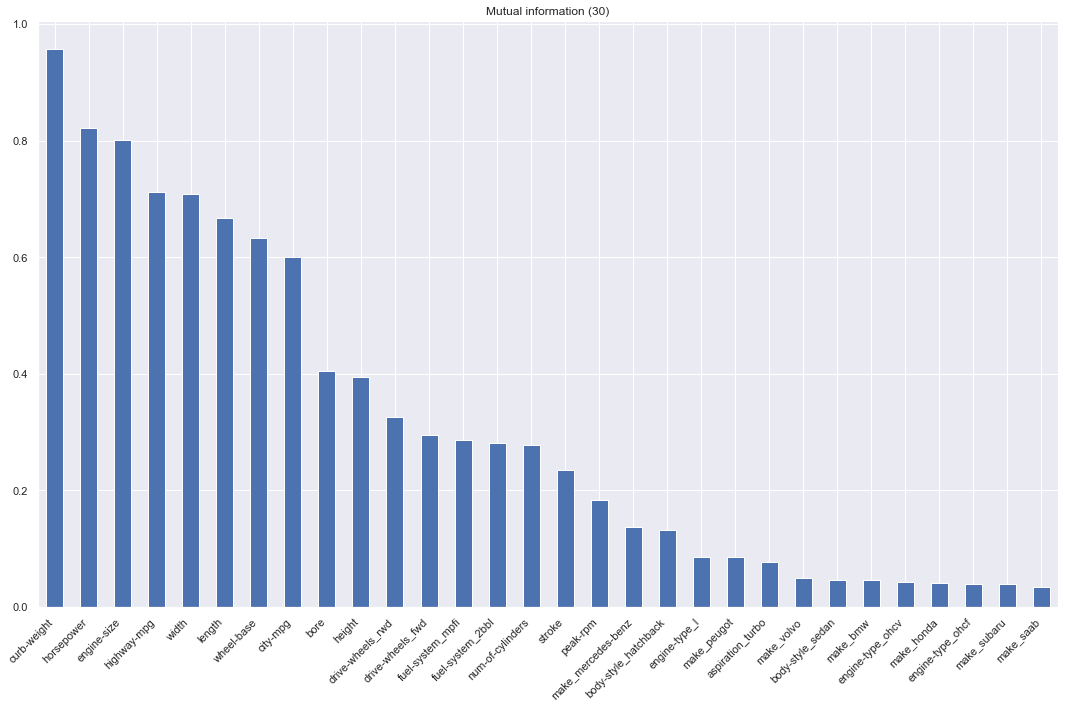

In [28]:
from sklearn.feature_selection import mutual_info_regression

plt.figure(figsize=(15,10))

mi = mutual_info_regression(X_train_, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_train_.columns).sort_values(ascending = False)

# lets plot the top 30
PLOT_NUM = 30
mi_series[:PLOT_NUM].plot.bar(legend = False, figsize=(15,10))
plt.title('Mutual information (' + str(PLOT_NUM) + ')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
#plt.savefig('mutual_information.png', dpi=300)
plt.show()

In [29]:
# filter only correlations stronger than .1 in either direction (positive or negative)
mis = mi_series>0.4
pd.DataFrame(X_train_.loc[:,mis]).head()

,wheel-base,length,width,curb-weight,engine-size,bore,horsepower,city-mpg,highway-mpg
0,94.5,165.3,63.8,1918.0,97.0,3.15,69.0,31.0,37.0
1,93.7,157.3,63.8,1918.0,90.0,2.97,68.0,37.0,41.0
2,102.4,175.6,66.5,2414.0,122.0,3.31,92.0,27.0,32.0
3,96.5,167.5,65.2,2236.0,110.0,3.15,86.0,27.0,33.0
4,96.9,173.6,65.4,2420.0,108.0,3.62,82.0,23.0,29.0


In [30]:
tidy_scores(cross_validate(LinearRegression(), pd.DataFrame(X_train_.loc[:,mis]), y_train, 
                           cv=KFold(5, shuffle=True, random_state=42), return_train_score=True, verbose=2))

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.0,0.81,0.86
1,0.01,0.0,0.79,0.86
2,0.00,0.0,0.92,0.83
3,0.00,0.0,0.82,0.86
4,0.01,0.0,0.69,0.87
mean,0.00,0.0,0.81,0.85
sd,0.00,0.0,0.07,0.01
